<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import itertools
import os

from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Model
from keras.utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from scipy.signal import find_peaks
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# matplotlib.__version__ #-> should not be 3.1.1
filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.
/Users/jiahao/anaconda3/envs/iss/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jiahao/anaconda3/envs/iss/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jiahao/anaconda3/envs/iss/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jiahao/anaconda3/en

In [3]:
# set data folder path
# DATA_FOLDER = 'D:\\NUS\\semester 2\\Course 3\\CA\\MAREA_dataset'
DATA_FOLDER = './MAREA_dataset'
# DATA_FOLDER = r'D:/NUS_TERM2_CA3/MAREA_dataset'
# DATA_FOLDER = 'C:/Users/david/Documents/CA3/MAREA_dataset-201/MAREA_dataset'
ACTIVITY_FOLDER = os.path.join(DATA_FOLDER, 'Activity Timings')
SUBJECT_FOLDER = os.path.join(DATA_FOLDER, 'Subject Data_txt format')
PROCESSED_FOLDER = os.path.join(DATA_FOLDER, 'Processed_data')

# define activity timing labels
label_indoor = ['tread_flat_walk_start',
                'tread_flat_walk_end',
                'tread_flat_run_end',
                'tread_slope_walk_start',
                'tread_slope_walk_end',
                'indoor_flat_walk_start',
                'indoor_flat_walk_end',
                'indoor_flat_run_end']

label_outdoor = ['outdoor_walk_start',
                 'outdoor_walk_end',
                 'outdoor_run_end']

# prepare timing index for different activities
df_indoor_time = pd.read_csv(os.path.join(ACTIVITY_FOLDER, 'Indoor Experiment Timings.txt')
                             , names=label_indoor)

df_outdoor_time = pd.read_csv(os.path.join(ACTIVITY_FOLDER, 'Outdoor Experiment Timings.txt')
                              , names=label_outdoor)

df_indoor_time["subject"] = ["Sub" + str(i) for i in range(1, 12)]
df_outdoor_time["subject"] = ["Sub" + str(j) for j in range(12, 21)]

In [16]:
# set up activity column names
axis_list = ['accX', 'accY', 'accZ']
pos_list = ['LF', 'RF', 'Waist', 'Wrist']
sub_list = ['Sub' + str(i) for i in range(1, 21)]
column_names = [f"{y}_{x}" for x, y in itertools.product(pos_list, axis_list)]

# TODO: purposely exclude subject 4 first as missing data -- dont know how to deal with missing data for signal
sub_list.remove('Sub4')

In [17]:
column_names

['accX_LF',
 'accY_LF',
 'accZ_LF',
 'accX_RF',
 'accY_RF',
 'accZ_RF',
 'accX_Waist',
 'accY_Waist',
 'accZ_Waist',
 'accX_Wrist',
 'accY_Wrist',
 'accZ_Wrist']

In [18]:
# create master dataframe
const_master_df = pd.DataFrame()
for sub in sub_list:
    df_lf = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'LF.txt'))
    df_rf = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'RF.txt'))
    df_waist = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'Waist.txt'))
    df_wrist = pd.read_csv(os.path.join(SUBJECT_FOLDER, sub + '_' + 'Wrist.txt'))
    df_sub = pd.concat([df_lf, df_rf, df_waist, df_wrist], axis=1)
    df_sub.columns = column_names

    df_sub = df_sub.copy()
    n = int(sub[3:])
    if n > 11:
        sub_row = df_outdoor_time[df_outdoor_time['subject'] == sub]
        tmp = sub_row.iloc[0]
        df_sub.loc[0:tmp['outdoor_walk_end'], 'label'] = 'outdoor_walk'
        df_sub.loc[tmp['outdoor_walk_end']: tmp['outdoor_run_end'], 'label'] = 'outdoor_run'
    else:
        sub_row = df_indoor_time[df_indoor_time['subject'] == sub]
        tmp = sub_row.iloc[0]
        df_sub.loc[0:tmp['tread_flat_walk_end'], 'label'] = 'tread_flat_walk'
        df_sub.loc[tmp['tread_flat_walk_end']: tmp['tread_flat_run_end'], 'label'] = 'tread_flat_run'
        df_sub.loc[tmp['tread_flat_run_end']: tmp['tread_slope_walk_start'], 'label'] = 'rest'
        df_sub.loc[tmp['tread_slope_walk_start']: tmp['tread_slope_walk_end'], 'label'] = 'tread_slope_walk'
        df_sub.loc[tmp['tread_slope_walk_end']: tmp['indoor_flat_walk_start'], 'label'] = 'rest'
        df_sub.loc[tmp['indoor_flat_walk_start']: tmp['indoor_flat_walk_end'], 'label'] = 'indoor_flat_walk'
        df_sub.loc[tmp['indoor_flat_walk_end']: tmp['indoor_flat_run_end'], 'label'] = 'indoor_flat_run'

    df_sub['subject'] = sub
    const_master_df = const_master_df.append(df_sub)
    # print(df.shape)

In [19]:
const_master_df.head(5)

,accX_LF,accY_LF,accZ_LF,accX_RF,accY_RF,accZ_RF,accX_Waist,accY_Waist,accZ_Waist,accX_Wrist,accY_Wrist,accZ_Wrist,label,subject
0,-2.196,-11.765,-1.569,4.078,-6.902,2.196,-0.157,-8.157,0.784,0.941,-11.451,-2.510,tread_flat_walk,Sub1
1,-2.510,-10.353,-2.039,4.392,-8.000,1.255,-0.157,-8.000,1.255,0.627,-10.510,-2.353,tread_flat_walk,Sub1
2,-2.353,-10.824,-2.510,4.863,-8.314,0.941,-0.157,-7.843,1.255,0.784,-10.196,-2.039,tread_flat_walk,Sub1
3,-1.882,-10.667,-2.667,4.549,-9.412,-0.157,-0.157,-8.000,1.412,1.255,-10.039,-1.412,tread_flat_walk,Sub1
4,-1.412,-10.353,-2.824,3.451,-10.353,-0.784,-0.627,-7.529,1.882,1.569,-10.196,-1.255,tread_flat_walk,Sub1


In [20]:
df = const_master_df.copy()

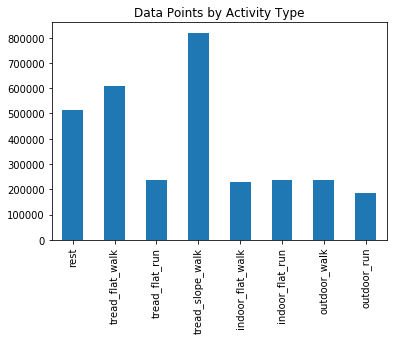

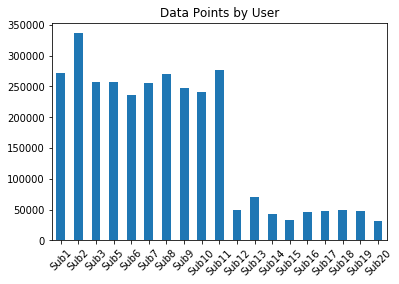

In [22]:
# Show how many training examples exist for each of the six activities

df['label'].value_counts() \
    .reindex(['rest',
            'tread_flat_walk',
            'tread_flat_run',
            'tread_slope_walk',
            'indoor_flat_walk',
            'indoor_flat_run',
            'outdoor_walk',
            'outdoor_run']) \
.plot(kind='bar',
      title='Data Points by Activity Type')

plt.savefig('activity_distribution.png', dpi=300)
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['subject'].value_counts() \
    .reindex(['Sub1',
                'Sub2',
                'Sub3',
#                 'Sub4',
                'Sub5',
                'Sub6',
                'Sub7',
                'Sub8',
                'Sub9',
                'Sub10',
                'Sub11',
                'Sub12',
                'Sub13',
                'Sub14',
                'Sub15',
                'Sub16',
                'Sub17',
                'Sub18',
                'Sub19',
                'Sub20']) \
    .plot(kind='bar',
          title='Data Points by User')
plt.xticks(rotation=45)
plt.savefig('user_distribution.png', dpi=300)
plt.show()

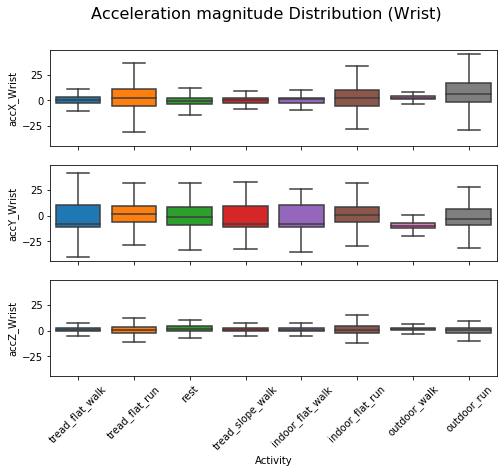

In [26]:
# Acceleration Magnitude Check
fig, (ax1, ax2, ax3) = plt.subplots(3, 
                                    sharex=True, sharey=True, 
                                    figsize=(8, 6))
fig.suptitle("Acceleration magnitude Distribution (Wrist)", fontsize=16)
plt.xticks(rotation=45)

# different axis - (a)
sns.boxplot(x='label', 
            y='accX_Wrist',
            data=df,
            showfliers=False,
            saturation=1,
            ax=ax1
           )
# ax1.set_title('accX_Wrist')
# ax1.axes.get_xaxis().set_visible(False)
ax1.xaxis.set_label_text("")

sns.boxplot(x='label', 
            y='accY_Wrist',
            data=df,
            showfliers=False,
            saturation=1,
            ax=ax2
           )
# ax2.set_title('accY_Wrist')
ax2.xaxis.set_label_text("")

sns.boxplot(x='label', 
            y='accZ_Wrist',
            data=df,
            showfliers=False,
            saturation=1,
            ax=ax3
           )
# ax3.set_title('accZ_Wrist')
ax3.xaxis.set_label_text("Activity")
plt.savefig('acceleration_magnitude_wrist.png', dpi=300)

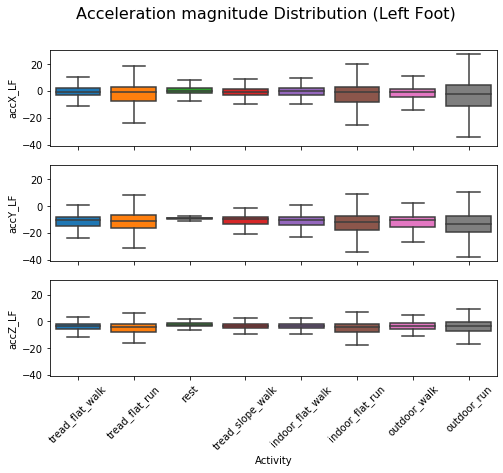

In [27]:
# Acceleration Magnitude Check
fig, (ax1, ax2, ax3) = plt.subplots(3, 
                                    sharex=True, sharey=True, 
                                    figsize=(8, 6))
fig.suptitle("Acceleration magnitude Distribution (Left Foot)", fontsize=16)
plt.xticks(rotation=45)

# different axis - (a)
sns.boxplot(x='label', 
            y='accX_LF',
            data=df,
            showfliers=False,
            saturation=1,
            ax=ax1
           )
# ax1.set_title('accX_Wrist')
# ax1.axes.get_xaxis().set_visible(False)
ax1.xaxis.set_label_text("")

sns.boxplot(x='label', 
            y='accY_LF',
            data=df,
            showfliers=False,
            saturation=1,
            ax=ax2
           )
# ax2.set_title('accY_Wrist')
ax2.xaxis.set_label_text("")

sns.boxplot(x='label', 
            y='accZ_LF',
            data=df,
            showfliers=False,
            saturation=1,
            ax=ax3
           )
# ax3.set_title('accZ_Wrist')
ax3.xaxis.set_label_text("Activity")
plt.savefig('acceleration_magnitude_lf.png', dpi=300)

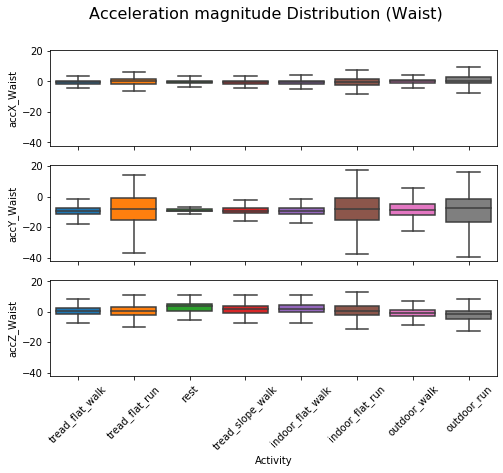

In [28]:
# Acceleration Magnitude Check
fig, (ax1, ax2, ax3) = plt.subplots(3, 
                                    sharex=True, sharey=True, 
                                    figsize=(8, 6))
fig.suptitle("Acceleration magnitude Distribution (Waist)", fontsize=16)
plt.xticks(rotation=45)

# different axis - (a)
sns.boxplot(x='label', 
            y='accX_Waist',
            data=df,
            showfliers=False,
            saturation=1,
            ax=ax1
           )
# ax1.set_title('accX_Wrist')
# ax1.axes.get_xaxis().set_visible(False)
ax1.xaxis.set_label_text("")

sns.boxplot(x='label', 
            y='accY_Waist',
            data=df,
            showfliers=False,
            saturation=1,
            ax=ax2
           )
# ax2.set_title('accY_Wrist')
ax2.xaxis.set_label_text("")

sns.boxplot(x='label', 
            y='accZ_Waist',
            data=df,
            showfliers=False,
            saturation=1,
            ax=ax3
           )
# ax3.set_title('accZ_Wrist')
ax3.xaxis.set_label_text("Activity")
plt.savefig('acceleration_magnitude_waist.png', dpi=300)

In [44]:
# 'rest',
# 'tread_flat_walk',
# 'tread_flat_run',
# 'tread_slope_walk',
# 'indoor_flat_walk',
# 'indoor_flat_run',
# 'outdoor_walk',
# 'outdoor_run'

# 'accX_LF',
#  'accY_LF',
#  'accZ_LF',
#  'accX_RF',
#  'accY_RF',
#  'accZ_RF',
#  'accX_Waist',
#  'accY_Waist',
#  'accZ_Waist',
#  'accX_Wrist',
#  'accY_Wrist',
#  'accZ_Wrist'

# 'Sub1',
# 'Sub2',
# 'Sub3',
# # 'Sub4',
# 'Sub5',
# 'Sub6',
# 'Sub7',
# 'Sub8',
# 'Sub9',
# 'Sub10',
# 'Sub11',
# 'Sub12',
# 'Sub13',
# 'Sub14',
# 'Sub15',
# 'Sub16',
# 'Sub17',
# 'Sub18',
# 'Sub19',
# 'Sub20'

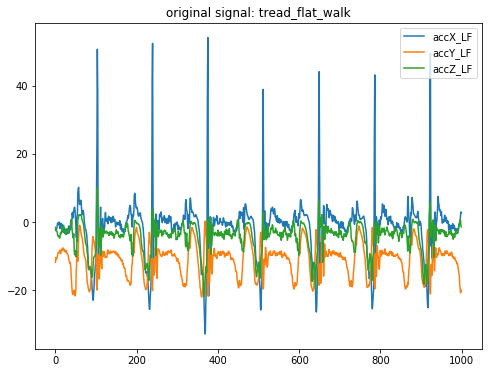

In [29]:
# Signal Exploration (three axis)
sub_or_act = 'tread_flat_walk'
feature_1 = 'accX_LF'
feature_2 = 'accY_LF'
feature_3 = 'accZ_LF'

explore_signal1 = df.ix[df['label']==sub_or_act, feature_1][0:1000]
explore_signal2 = df.ix[df['label']==sub_or_act, feature_2][0:1000]
explore_signal3 = df.ix[df['label']==sub_or_act, feature_3][0:1000]

plt.figure(figsize=(8, 6))
plt.plot(explore_signal1)
plt.plot(explore_signal2)
plt.plot(explore_signal3)
plt.title('Original Signal: '+sub_or_act)
plt.legend([feature_1, feature_2, feature_3], loc='upper right')
# Save figure for report
# plt.savefig('explore_1.png', dpi=300)
plt.show()

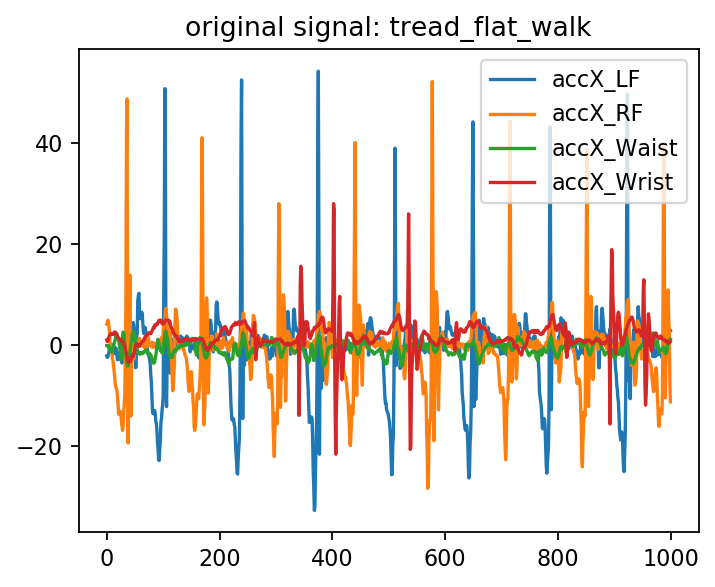

In [167]:
# Signal Exploration (four sensors)
sub_or_act = 'tread_flat_walk'
feature_1 = 'accX_LF'
feature_2 = 'accX_RF'
feature_3 = 'accX_Waist'
feature_4 = 'accX_Wrist'

explore_signal1 = df.ix[df['label']==sub_or_act, feature_1][0:1000]
explore_signal2 = df.ix[df['label']==sub_or_act, feature_2][0:1000]
explore_signal3 = df.ix[df['label']==sub_or_act, feature_3][0:1000]
explore_signal4 = df.ix[df['label']==sub_or_act, feature_4][0:1000]

plt.figure(figsize=(5, 4), dpi=160)
plt.plot(explore_signal1)
plt.plot(explore_signal2)
plt.plot(explore_signal3)
plt.plot(explore_signal4)
plt.title('original signal: '+sub_or_act)
plt.legend([feature_1, feature_2, feature_3, feature_4], loc='upper right')
# Save figure for report
# plt.savefig('explore_2.png', dpi=300)
plt.show()

In [ ]:
# TODO: not tried
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

Text(0.5, 1.0, 'accZ_LF')

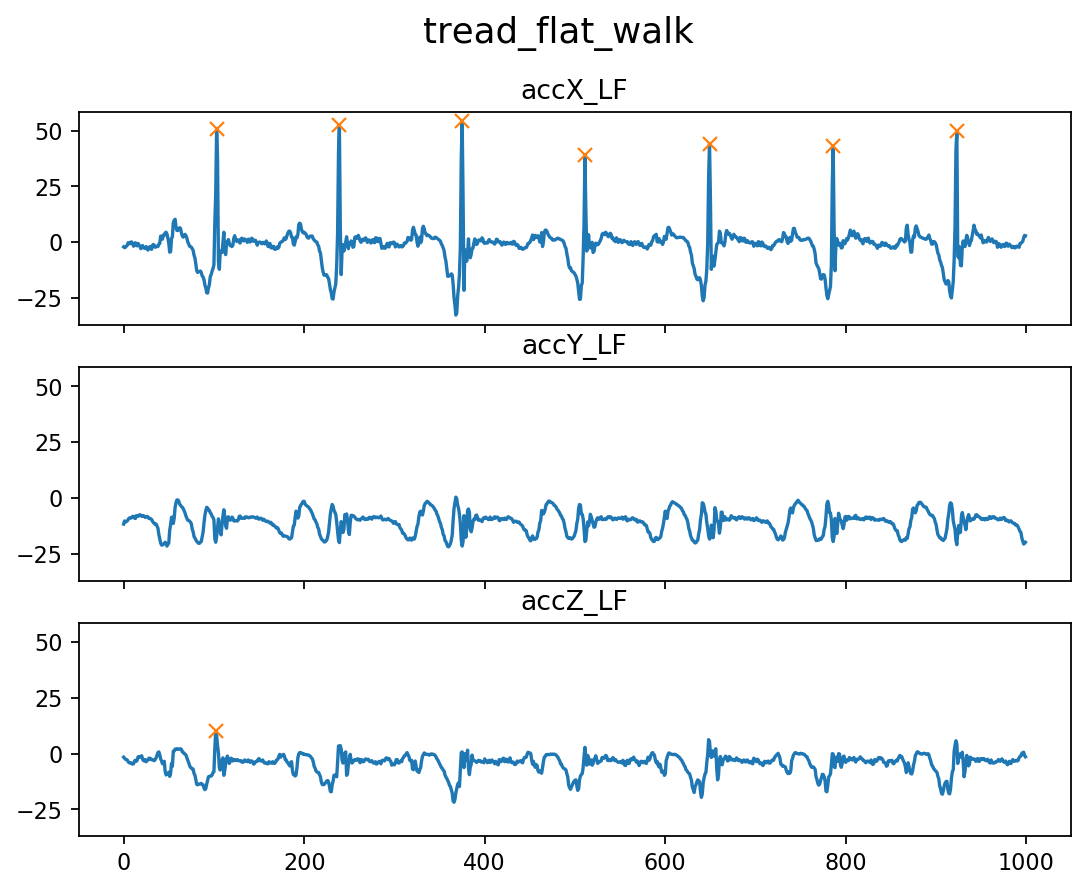

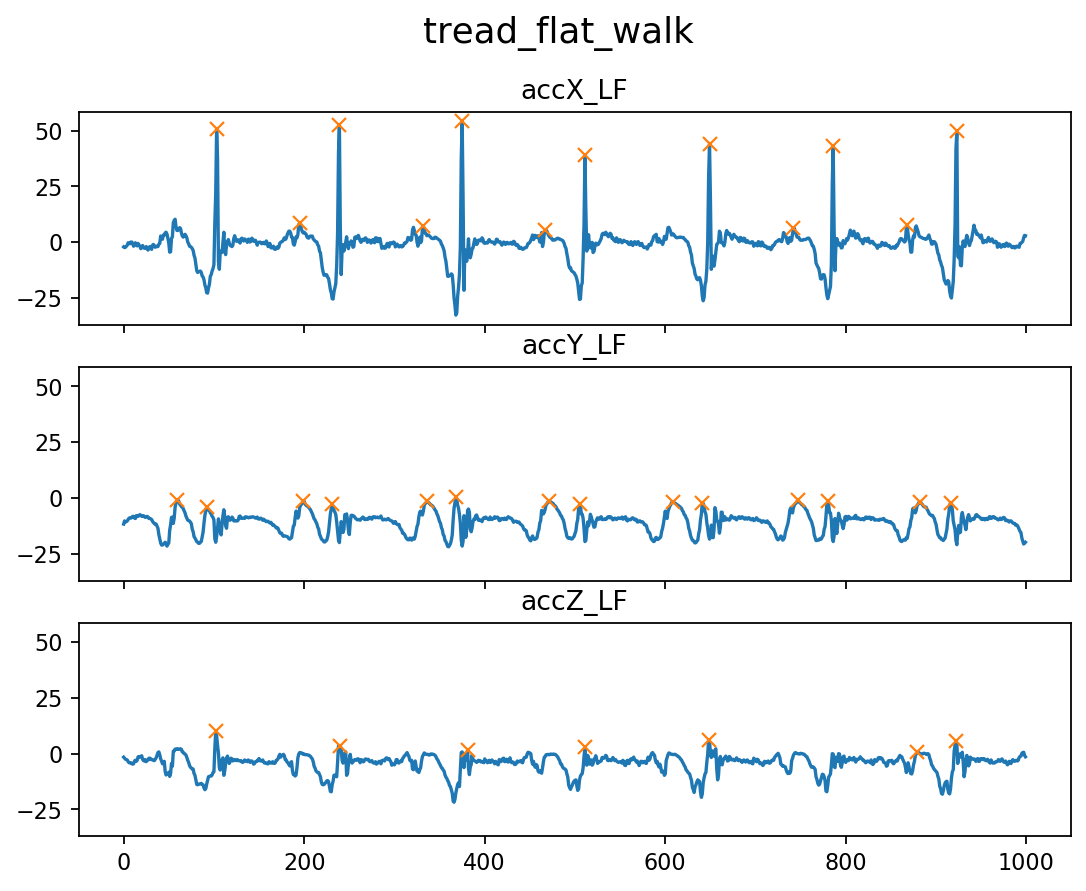

In [172]:
sub_or_act = 'tread_flat_walk'
feature_1 = 'accX_LF'
feature_2 = 'accY_LF'
feature_3 = 'accZ_LF'

explore_signal1 = df.ix[df['label']==sub_or_act, feature_1][0:1000]
explore_signal2 = df.ix[df['label']==sub_or_act, feature_2][0:1000]
explore_signal3 = df.ix[df['label']==sub_or_act, feature_3][0:1000]

# height, prominence - might be useful
# distance - can help to exclude some situation but may be variable based on users
# threshold - not applicabale since it only check "the vertical distance to its neighbouring samples"
# width - not applicable "width of peaks"

# Method 1: Find peak (1) distance and height base on first good axis

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(8, 6), dpi=160)
fig.suptitle("tread_flat_walk", fontsize=16)

# different axis - (a)
(somePks,_) = find_peaks(explore_signal1,
                        distance=100, 
                        height=10)
ax1.plot(explore_signal1)
ax1.plot(somePks,explore_signal1[somePks],'x')
ax1.set_title(feature_1)

# different axis - (b)
(somePks,_) = find_peaks(explore_signal2,
                        distance=100, 
                        height=10)
ax2.plot(explore_signal2)
ax2.plot(somePks,explore_signal2[somePks],'x')
ax2.set_title(feature_2)

# different axis - (c)
(somePks,_) = find_peaks(explore_signal3,
                        distance=100, 
                        height=10)
ax3.plot(explore_signal3)
ax3.plot(somePks,explore_signal3[somePks],'x')
ax3.set_title(feature_3)

# Conclusiton: proved not a good result in different axis


# Method 2: Find peak by prominence

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(8, 6), dpi=160)
fig.suptitle("tread_flat_walk", fontsize=16)

# different axis - (a)
(somePks,_) = find_peaks(explore_signal1,
                        prominence=15)
ax1.plot(explore_signal1)
ax1.plot(somePks,explore_signal1[somePks],'x')
ax1.set_title(feature_1)

# different axis - (b)
(somePks,_) = find_peaks(explore_signal2,
                        prominence=15)
ax2.plot(explore_signal2)
ax2.plot(somePks,explore_signal2[somePks],'x')
ax2.set_title(feature_2)

# different axis - (c)
(somePks,_) = find_peaks(explore_signal3,
                        prominence=15)
ax3.plot(explore_signal3)
ax3.plot(somePks,explore_signal3[somePks],'x')
ax3.set_title(feature_3)

In [116]:
# Baseline Correction

def alsbase(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

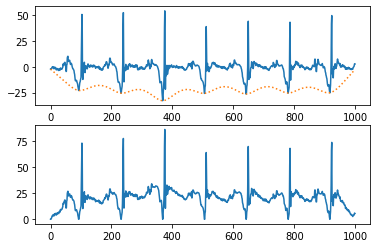

In [117]:
ecgbase = alsbase(explore_signal1, 10^5,0.000005,niter=50)
ecgcorr = explore_signal1-ecgbase
plt.figure()
plt.subplot(211)
plt.plot(explore_signal1)
plt.plot(ecgbase,
    color="C1",
    linestyle='dotted')
plt.subplot(212)
plt.plot(ecgcorr)

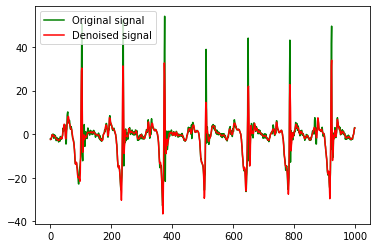

In [181]:
# Wavelet Transformation
signal_orig = explore_signal1

# Step 0: Configuration of wavelet decomposition

waveletname = 'db4'
waveletlevel = 2

coeffs_orig = pywt.wavedec(signal_orig, waveletname, level=waveletlevel)
coeffs_filter = coeffs_orig.copy()

threshold = 0.8

for i in range(1, len(coeffs_orig)):
    coeffs_filter[i] = pywt.threshold(coeffs_orig[i], threshold*max(coeffs_orig[i]))

signal_denoised = pywt.waverec(coeffs_filter, waveletname)

plt.figure()
plt.plot(signal_orig, 'g', label='Original signal')
plt.plot(signal_denoised, 'r', label='Denoised signal')
plt.legend()
plt.show()


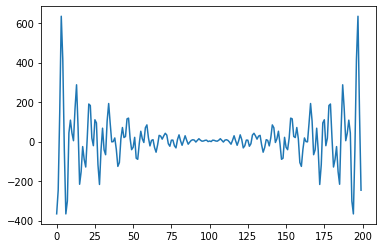

In [184]:
# FFT
import scipy.fftpack

yf = scipy.fftpack.fft(signal_orig[56:256])

fig, ax = plt.subplots()
ax.plot(yf)
plt.show()